In [7]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import random
import math
from PIL import Image
import matplotlib.pyplot as plt

In [8]:
# method to load MNIST dataset


def load_minst(minst_dataset):
    data_dict = {}

    for file_name in minst_dataset:
        if file_name.endswith('ubyte'):
            with open(file_name, 'rb') as f:
                data = f.read()
                type = get_int(data[:4])
                length = get_int(data[4:8])
                if (type == 2051):
                    category = 'images'
                    num_rows = get_int(data[8:12])
                    num_cols = get_int(data[12:16])
                    parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
                    parsed = parsed.reshape(length, num_rows, num_cols)
                elif (type == 2049):
                    category = 'labels'
                    parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
                    parsed = parsed.reshape(length)
                if (length == 10000):
                    set = 'test'
                elif (length == 60000):
                    set = 'train'
                data_dict[set + '_' + category] = parsed

    return data_dict


def get_int(byte):
    return int.from_bytes(byte, "big")


mints_dataset_file_names = ["train-images-idx3-ubyte", "train-labels-idx1-ubyte", "t10k-images-idx3-ubyte",
                                "t10k-labels-idx1-ubyte"]

mnist_dict = load_minst(mints_dataset_file_names)


In [9]:
# Preparing train, test split

train_images = np.copy(mnist_dict['train_images'])
train_labels = np.copy(mnist_dict['train_labels'])
test_images = np.copy(mnist_dict['test_images'])
test_labels = mnist_dict['test_labels']


# converting to 28*28 images to 1-d array

train_images = np.reshape(train_images, (train_images.shape[0], train_images.shape[1] * train_images.shape[2]))
test_images = np.reshape(test_images, (test_images.shape[0], test_images.shape[1] * test_images.shape[2]))

<Figure size 432x288 with 0 Axes>

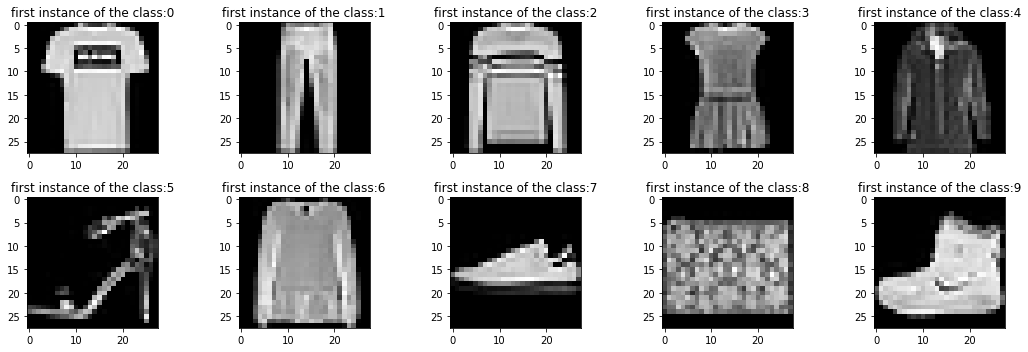

In [10]:
# visualizing all the 10 classes of the train images

indexes = np.zeros(10)

for i in range(len(indexes)):
    for j in range(len(train_labels)):
    
        if train_labels[j] == i:
            indexes[i] = j
            break        


plt.figure()
f, axarr = plt.subplots(2,5) 
f.set_figheight(5)
f.set_figwidth(15)

cntr = 0

for i in range(2):
    for j in range(5):
        axarr[i][j].imshow(np.reshape(train_images[int(indexes[cntr])], (28, 28)), cmap='gray')
        axarr[i][j].set_title('first instance of the class:' + str(cntr))
        cntr +=1
        
plt.tight_layout()

In [11]:
# preprocessing, scaling the data between 0 and 1 

from sklearn.preprocessing import MinMaxScaler

scaled_train_images = MinMaxScaler().fit_transform(train_images)
scaled_test_images = MinMaxScaler().fit_transform(test_images)

In [12]:
# initializing knn methods, for learning optimal parameters

from sklearn.neighbors import KNeighborsClassifier

knns = []
n_neighbors = [5, 11, 15, 25]

# I initially tested with both uniform and distance but since distance outperformed uniform at each training object
# therefore i just used distance in this parameter
weights = ['distance'] 
algorithms = ['ball_tree', 'kd_tree'] # initillay tuned the brute parameter too but takes to much time with little improvment on accuracy

# same thing with the p value p value 1 outformed the p value 2 therefore for saving time I omitted this value
ps = [1]

for i in range(len(n_neighbors)):
    for j in range(len(weights)):
        for k in range(len(algorithms)):
            for x in range(len(ps)):
                n_count = n_neighbors[i]
                weight = weights[j]
                algorithm = algorithms[k]
                p = ps[x]
                knn = KNeighborsClassifier(n_neighbors=n_count, weights=weight, algorithm= algorithm, p=p)
                knns.append(knn)

In [13]:
# fitting knn methods

import time

time_passed_knn_fit = []
start = time.time()


for i in range(len(knns)):
    knns[i].fit(scaled_train_images, train_labels)
    
    end = time.time()
    pass_time = end - start
    time_passed_knn_fit.append(pass_time)
    print('at iteration', i, 'passed seconds= ', int(pass_time))
    

at iteration 0 passed seconds=  47
at iteration 1 passed seconds=  100
at iteration 2 passed seconds=  144
at iteration 3 passed seconds=  197
at iteration 4 passed seconds=  246
at iteration 5 passed seconds=  340
at iteration 6 passed seconds=  395
at iteration 7 passed seconds=  450


In [14]:
# getting predictions for each knn object
import time

predictions = []
time_passed_knn_predict = []
start = time.time()

for i in range(len(knns)):
    prediction = knns[i].predict(scaled_test_images)
    end = time.time()
    pass_time = end - start
    
    time_passed_knn_predict.append(pass_time)
    predictions.append(prediction)
    
    print('at iteration', i, 'passed seconds= ', pass_time)
    start = time.time()

at iteration 0 passed seconds=  538.1723392009735
at iteration 1 passed seconds=  631.5267431735992
at iteration 2 passed seconds=  575.2360455989838
at iteration 3 passed seconds=  623.7138044834137
at iteration 4 passed seconds=  613.7450888156891
at iteration 5 passed seconds=  905.4551498889923
at iteration 6 passed seconds=  804.1509096622467
at iteration 7 passed seconds=  609.8123257160187


In [15]:
# getting the accuracy score so we can choose right hyperparameters

from sklearn.metrics import accuracy_score

accuracies_knns = [] 
max_score_knn_ind = 0
max_score_knn = 0
for i in range(len(predictions)):
    
    score = accuracy_score(test_labels, predictions[i])
    
    if score > max_score_knn:
        max_score_knn_ind = i
        max_score_knn = score
        
    accuracies_knns.append(score)

In [16]:
# for converting int labels into strings 

class_dict = dict({ '0': 'Top', '1' : 'Trouser', '2' : 'Pullover', '3' : 'Dress', '4' : 'Coat', '5' : 'Sandals', '6' : 'Shirt', '7' : 'Sneaker', '8' : 'Bag', '9' : 'Boots'})

In [17]:
# for getting correctly classified and incorrectly classified unique 10 instances

def get_correct_and_incorrect_instances(max_score_ind, predictions):
    
    desired_predictions_array = predictions[max_score_ind]

    for_plotting_predictions_correct_instances = np.zeros((10, 784))
    for_plotting_predictions_incorrect_instances = np.zeros((10, 784))

    correct_instances = np.zeros(10)
    incorrect_instances = np.zeros(10)
    for i in range(len(incorrect_instances)):
        incorrect_instances[i] = -1

    for i in range(len(desired_predictions_array)):

        prediction = desired_predictions_array[i]
        correct_label = test_labels[i]
        test_image = scaled_test_images[i]

        if prediction == correct_label and correct_instances[correct_label] == 0:
            correct_instances[correct_label] = 1
            for_plotting_predictions_correct_instances[correct_label] = test_image

        elif prediction != correct_label and incorrect_instances[prediction] == -1:
            incorrect_instances[correct_label] = prediction
            for_plotting_predictions_incorrect_instances[correct_label] = test_image

        if 0 not in correct_instances and -1 not in incorrect_instances:
            break
            
    return incorrect_instances, for_plotting_predictions_correct_instances, for_plotting_predictions_incorrect_instances
        

In [18]:
def plot_correct_and_incorrect_instances(incorrect_instances, plt_correct_instances, plt_incorrect_instances, algo):
    
    plt.figure()
    f, axarr = plt.subplots(2,10) 
    f.set_figheight(15)
    f.set_figwidth(35)


    for i in range(2):
        for j in range(10):

            if i == 0: # means we are printing correct instances
                axarr[i][j].imshow(np.reshape(plt_correct_instances[j], (28, 28)), cmap='gray')
                title = class_dict[str(j)] + ' classified correctly'
                axarr[i][j].set_title(title, fontsize=19)

            else:
                correct_label = int(j)
                prediction = int(incorrect_instances[j])
                if prediction == -1:
                    title = 'all instances of this class are \n correctly classified'
                    axarr[i][j].imshow(np.reshape(np.zeros(784), (28, 28)), cmap='gray')
                    axarr[i][j].set_title(title, fontsize=19)

                else:
                    title = 'belonged to ' + class_dict[str(j)] + '\n classified as ' + class_dict[str(prediction)]
                    axarr[i][j].imshow(np.reshape(plt_incorrect_instances[j], (28, 28)), cmap='gray')
                    axarr[i][j].set_title(title, fontsize=19)

    plt.title('algorithm is ' + str(algo))
    plt.tight_layout()

<Figure size 432x288 with 0 Axes>

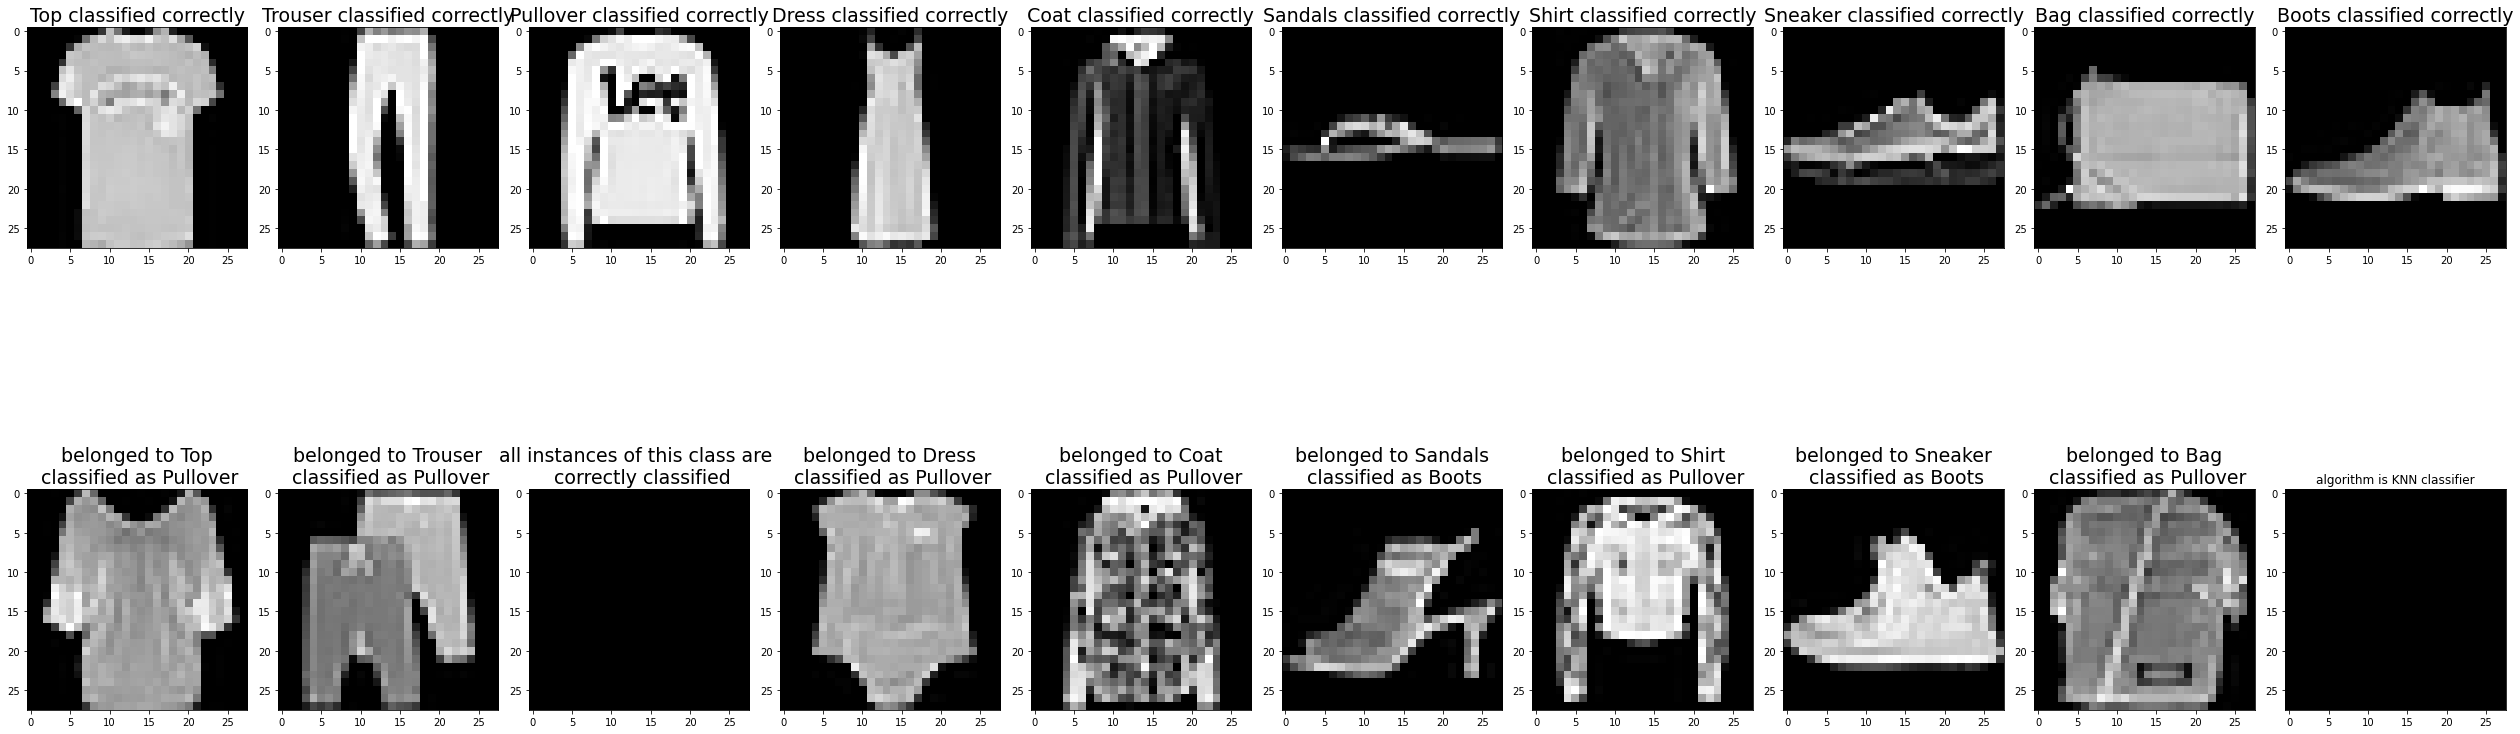

In [19]:
inc_inst_knn, corr_inst_knn, incorr_inst_knn = get_correct_and_incorrect_instances(max_score_knn_ind, predictions)
plot_correct_and_incorrect_instances(inc_inst_knn, corr_inst_knn, incorr_inst_knn, algo='KNN classifier')

In [70]:
# sorting indeces

idx_acc_sorted = sorted(range(len(accuracies_knns)),key=accuracies_knns.__getitem__)

In [71]:
# preparing sorted list

idx_acc_sorted

accs_sorted = []
knns_sorted = []

for i in range(len(accuracies_knns)):
    accs_sorted.append(accuracies_knns[idx_acc_sorted[i]])
    knns_sorted.append(knns[idx_acc_sorted[i]])

In [72]:
# getting knn objects parameters

params_all = []

for i in range(len(knns_sorted)):
    params = str(knns_sorted[i].get_params)
    params = params[params.find("(")+1:params.find(")")]
    params_all.append(params)



Text(0.5, 1.0, 'Knn accuracies with adjusted hyperparameters plotted')

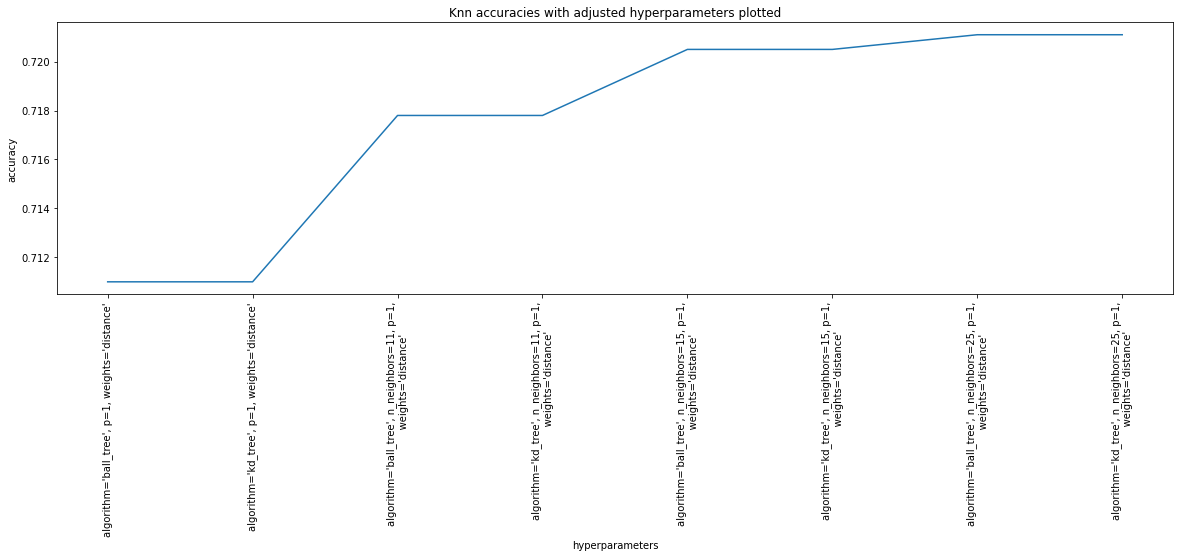

In [73]:
# plotting every two objects since printing all the objects needs to big plot 

plt.figure(figsize=(20, 5))
plt.plot(np.arange(len(knns)), accs_sorted)
plt.xticks(np.arange(len(knns)), params_all, rotation= 90)
plt.xlabel('hyperparameters')
plt.ylabel('accuracy')
plt.title('Knn accuracies with adjusted hyperparameters plotted')

In [74]:
def draw_conf_matrix(conf_matrix, acc, algo, params):
    classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix)

    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    for i in range(len(classes)):
       for j in range(len(classes)):
           text = ax.text(j, i, conf_matrix[i, j],
                          ha="center", va="center", color="w")

    if algo == 'knn':                  
        ax.set_title("Confusion matrix of the knn classifier \n accuracy= %" + str(acc * 100) + '\n params= ' + str(params))

    elif algo == 'perceptron':
        ax.set_title("Confusion matrix of the perceptron algorithm \n accuracy= %" + str(acc * 100) + '\n params= ' + str(params))

    elif algo == 'svm':
        ax.set_title("Confusion matrix of the svm algorithm \n accuracy= %" + str(acc * 100) + '\n params= ' + str(params))
    elif algo == 'decision tree':
        ax.set_title("Confusion matrix of the decision tree algorithm \n accuracy= %" + str(acc * 100) + '\n params= ' + str(params))

    else:
        ax.set_title("Confusion matrix of the random fores algorithm \n accuracy= %" + str(acc * 100) + '\n params= ' + str(params))




    fig.tight_layout()
    plt.show()


In [75]:
# from the plot and also from the sorted list the optimal knn parameters are, so i will use this hyperparameters when testing:

optimal_knn = knns_sorted[-1]

knns_sorted[-1].get_params, accs_sorted[-1]

(<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='kd_tree', n_neighbors=25, p=1,
                      weights='distance')>,
 0.7211)

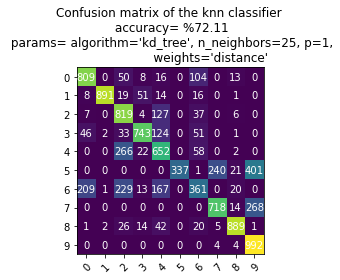

In [76]:
# getting the confusion matrix of the optimal knn classifier 

from sklearn.metrics import confusion_matrix

class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

confusion_matrix_optimal_knn = confusion_matrix(test_labels, predictions[max_score_knn_ind])

draw_conf_matrix(confusion_matrix_optimal_knn, accs_sorted[-1], algo='knn', params=params_all[-1])

In [77]:
# initializing perceptron model

from sklearn.linear_model import Perceptron

# listing hyperparameters to be adjusted

penalty = ['l2', 'l1', 'elasticnet', None]
alpha = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
fit_intercept = [True, False]
tol = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]

perceptrons = []
params_all = []

for i in range(len(penalty)):
    for j in range(len(alpha)):
        for k in range(len(fit_intercept)):
            for x in range(len(tol)):
                pen = penalty[i]
                alp = alpha[j]
                fit_inter = fit_intercept[k]
                tol_ = tol[i]
                if pen is not None:
                    perceptron = Perceptron(penalty=pen, alpha=alp, fit_intercept=fit_inter, tol=tol_)
                else:
                    perceptron = Perceptron(fit_intercept=fit_inter, tol=tol_)
                
                perceptrons.append(perceptron)

                


In [78]:
# for deleting same objects since i made a mistake in the cell above but because it would be too long i will change them here

perceptrons_new = []
params_new  = []

for i in range(len(perceptrons)):
    params_of_the_perceptron = str(perceptrons[i].get_params)
    if params_of_the_perceptron not in params_new:
        params_new.append(params_of_the_perceptron)
        perceptrons_new.append(perceptrons[i])

In [79]:
perceptrons = perceptrons_new

In [80]:
# fitting the perceptron models
start = time.time()
pass_time_fit_perceptron = []

for i in range(len(perceptrons)):
    perceptrons[i].fit(scaled_train_images, train_labels)
    
    end = time.time()
    pass_time = end - start
    
    pass_time_fit_perceptron.append(pass_time)
    
    print('at iteration=',i, 'time passed in seconds is=', int(pass_time))
    start= time.time()
    

at iteration= 0 time passed in seconds is= 5
at iteration= 1 time passed in seconds is= 5
at iteration= 2 time passed in seconds is= 5
at iteration= 3 time passed in seconds is= 5
at iteration= 4 time passed in seconds is= 5
at iteration= 5 time passed in seconds is= 5
at iteration= 6 time passed in seconds is= 4
at iteration= 7 time passed in seconds is= 4
at iteration= 8 time passed in seconds is= 4
at iteration= 9 time passed in seconds is= 5
at iteration= 10 time passed in seconds is= 4
at iteration= 11 time passed in seconds is= 5
at iteration= 12 time passed in seconds is= 5
at iteration= 13 time passed in seconds is= 5
at iteration= 14 time passed in seconds is= 11
at iteration= 15 time passed in seconds is= 11
at iteration= 16 time passed in seconds is= 12
at iteration= 17 time passed in seconds is= 12
at iteration= 18 time passed in seconds is= 17
at iteration= 19 time passed in seconds is= 20
at iteration= 20 time passed in seconds is= 19
at iteration= 21 time passed in secon

In [81]:
# predictions for each perceptron object

predictions_perceptron = []
time_spend_perceptron_predict = []
start = time.time()

for i in range(len(perceptrons)):
    prediction = perceptrons[i].predict(scaled_test_images)
    end = time.time()
    pass_time = end - start
    
    predictions_perceptron.append(prediction)
    time_spend_perceptron_predict.append(pass_time)
    print('at iteration', i, 'passed seconds= ', pass_time)
    start = time.time()

at iteration 0 passed seconds=  0.8908936977386475
at iteration 1 passed seconds=  0.01997971534729004
at iteration 2 passed seconds=  0.018981218338012695
at iteration 3 passed seconds=  0.0169830322265625
at iteration 4 passed seconds=  0.016982555389404297
at iteration 5 passed seconds=  0.017980575561523438
at iteration 6 passed seconds=  0.0169827938079834
at iteration 7 passed seconds=  0.0169830322265625
at iteration 8 passed seconds=  0.01698160171508789
at iteration 9 passed seconds=  0.017981767654418945
at iteration 10 passed seconds=  0.016982078552246094
at iteration 11 passed seconds=  0.01798272132873535
at iteration 12 passed seconds=  0.017981290817260742
at iteration 13 passed seconds=  0.01698160171508789
at iteration 14 passed seconds=  0.017981767654418945
at iteration 15 passed seconds=  0.015989065170288086
at iteration 16 passed seconds=  0.0169827938079834
at iteration 17 passed seconds=  0.018979787826538086
at iteration 18 passed seconds=  0.01798176765441894

In [82]:
# getting accuracy scores for the perceptron objects

accs_perceptron = []

max_acc_perceptron = 0
max_acc_perceptron_ind = 0

for i in range(len(predictions_perceptron)):
    
    score = accuracy_score(test_labels, predictions_perceptron[i])
    
    if score > max_acc_perceptron:
        max_acc_perceptron = score
        max_acc_perceptron_ind = i
        
    accs_perceptron.append(score)


<Figure size 432x288 with 0 Axes>

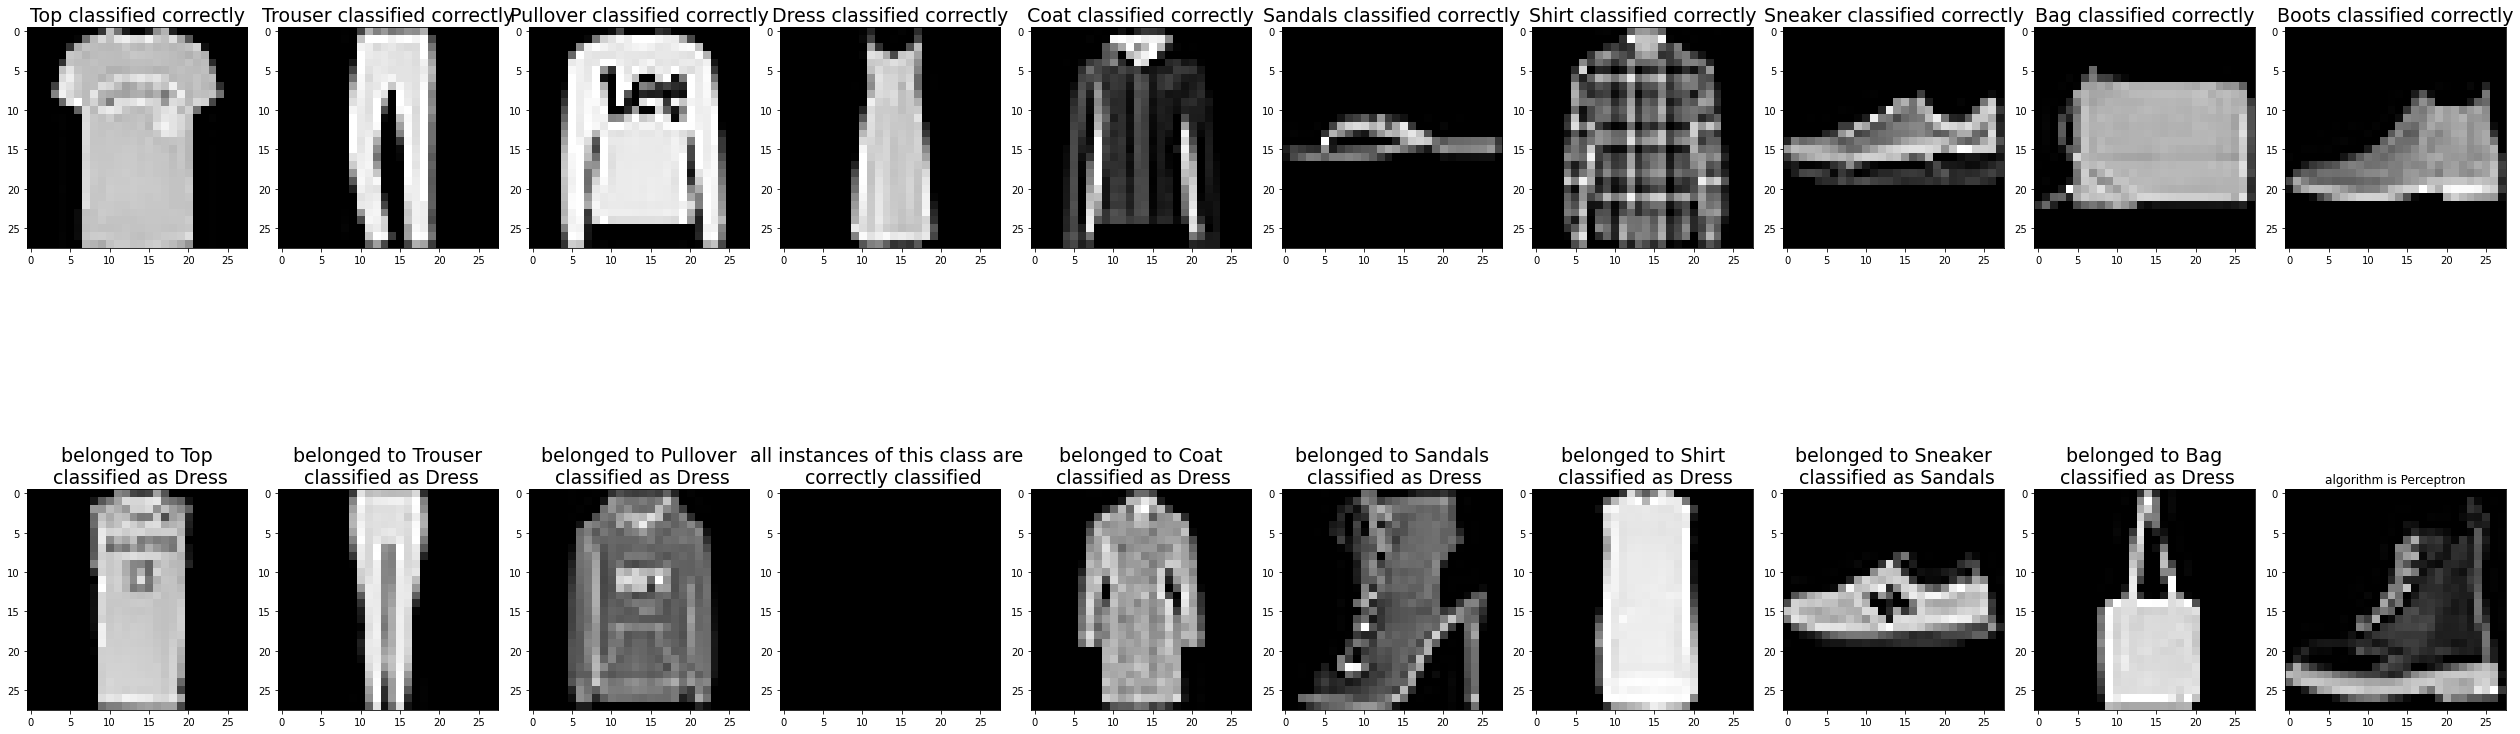

In [83]:
inc_inst_perc, corr_inst_perc, incorr_inst_perc = get_correct_and_incorrect_instances(max_acc_perceptron_ind, predictions_perceptron)
plot_correct_and_incorrect_instances(inc_inst_perc, corr_inst_perc, incorr_inst_perc, algo='Perceptron')

In [84]:
# sorting perceptron accs indeces

idx_acc_sorted_perceptron = sorted(range(len(accs_perceptron)),key=accs_perceptron.__getitem__)

In [85]:
# preparing sorted list

accs_sorted_perceptron = []
perceptrons_sorted = []

for i in range(len(accs_perceptron)):
    accs_sorted_perceptron.append(accs_perceptron[idx_acc_sorted_perceptron[i]])
    perceptrons_sorted.append(perceptrons[idx_acc_sorted_perceptron[i]])

In [86]:
# getting perceptron objects parameters

params_all_perceptron = []

for i in range(len(perceptrons_sorted)):
    params = str(perceptrons_sorted[i].get_params)
    params = params[params.find("(")+1:params.find(")")]
    params_all_perceptron.append(params)



Text(0.5, 1.0, 'Perceptron accuracies with adjusted hyperparameters plotted')

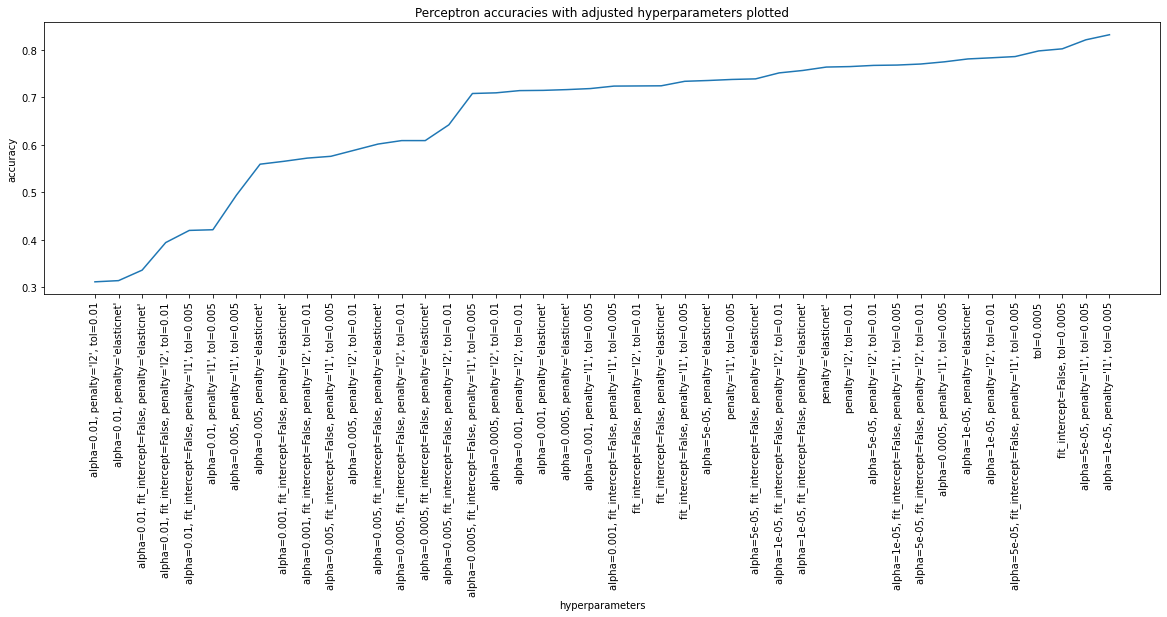

In [87]:
# plotting highest accuracy 50 perceptron objects since printing all the objects needs to big plot 

plt.figure(figsize=(20, 5))
plt.plot(np.arange(len(accs_sorted_perceptron)), accs_sorted_perceptron)
plt.xticks(np.arange(len(params_all_perceptron)), params_all_perceptron, rotation= 90)
plt.xlabel('hyperparameters')
plt.ylabel('accuracy')
plt.title('Perceptron accuracies with adjusted hyperparameters plotted')

In [88]:
# now getting optimal perceptron model

optimal_perceptron = perceptrons_sorted[-1]
optimal_perceptron

Perceptron(alpha=1e-05, penalty='l1', tol=0.005)

In [89]:
optimal_perceptron.get_params(True)

{'alpha': 1e-05,
 'class_weight': None,
 'early_stopping': False,
 'eta0': 1.0,
 'fit_intercept': True,
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 0,
 'shuffle': True,
 'tol': 0.005,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

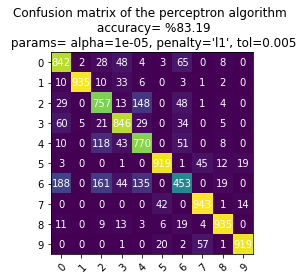

In [90]:
# getting the confusion matrix of the optimal perceptron classifier 

from sklearn.metrics import confusion_matrix

class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

confusion_matrix_optimal_perceptron = confusion_matrix(test_labels, predictions_perceptron[max_acc_perceptron_ind])

draw_conf_matrix(confusion_matrix_optimal_perceptron, accs_sorted_perceptron[-1], algo='perceptron', params=params_all_perceptron[-1])

In [91]:
# initiliazing different svc objects

from sklearn.svm import SVC

svcs = []

c_s = [0.9, 1, 1.1]
kernels = ['linear', 'poly', 'rbf'] 
degrees = [3, 4]
gammas = ['scale']

for i in range(len(c_s)):
    for j in range(len(kernels)):
        c = c_s[i]
        kernel = kernels[j]
        
        if kernel == 'poly':
            for k in range(len(degrees)):
                degree = degrees[k]
                for x in range(len(gammas)):
                    gamma = gammas[x]
                    svc_ = SVC(C=c, kernel=kernel, degree=degree, gamma=gamma)
                    svcs.append(svc_)
                    
        elif kernel == 'rbf' or kernel == 'sigmoid':
            for k in range(len(gammas)):
                gamma = gammas[k]
                scv_ = SVC(C=c, kernel=kernel, gamma=gamma)
                svcs.append(svc_)

                
        else:
            svc_ = SVC(C=c, kernel=kernel)
            svcs.append(svc_)

len(svcs)

12

In [92]:
# fitting svc objects

start = time.time()
times = []

for i in range(len(svcs)):
    svcs[i].fit(scaled_train_images, train_labels)
    
    end = time.time()
    pass_time = end - start
    
    print('at iteration=',i, 'time passed in seconds is=', int(pass_time))
    times.append(pass_time)
    start= time.time()

at iteration= 0 time passed in seconds is= 470
at iteration= 1 time passed in seconds is= 502
at iteration= 2 time passed in seconds is= 578
at iteration= 3 time passed in seconds is= 592
at iteration= 4 time passed in seconds is= 482
at iteration= 5 time passed in seconds is= 494
at iteration= 6 time passed in seconds is= 574
at iteration= 7 time passed in seconds is= 570
at iteration= 8 time passed in seconds is= 500
at iteration= 9 time passed in seconds is= 488
at iteration= 10 time passed in seconds is= 628
at iteration= 11 time passed in seconds is= 594


In [93]:
pass_time_svm_fit = times

In [94]:
# predictions for each svm object

predictions_svm = []
time_spend_svm_predict = []
start = time.time()

for i in range(len(svcs)):
    prediction = svcs[i].predict(scaled_test_images)
    end = time.time()
    pass_time = end - start
    
    predictions_svm.append(prediction)
    time_spend_svm_predict.append(pass_time)
    print('at iteration', i, 'passed seconds= ', pass_time)
    start = time.time()

at iteration 0 passed seconds=  126.55226945877075
at iteration 1 passed seconds=  140.62500286102295
at iteration 2 passed seconds=  147.24222111701965
at iteration 3 passed seconds=  145.62786889076233
at iteration 4 passed seconds=  119.67304682731628
at iteration 5 passed seconds=  131.0381498336792
at iteration 6 passed seconds=  136.84728932380676
at iteration 7 passed seconds=  136.45788717269897
at iteration 8 passed seconds=  116.23196697235107
at iteration 9 passed seconds=  129.98319506645203
at iteration 10 passed seconds=  133.56063079833984
at iteration 11 passed seconds=  134.01500487327576


In [95]:
# getting accuracy scores for the svm objects

accs_svm = []

max_acc_svm = 0
max_acc_svm_ind = 0

for i in range(len(svcs)):
    
    score = accuracy_score(test_labels, predictions_svm[i])
    
    if score > max_acc_svm:
        max_acc_svm = score
        max_acc_svm_ind = i
        
    accs_svm.append(score)
    

<Figure size 432x288 with 0 Axes>

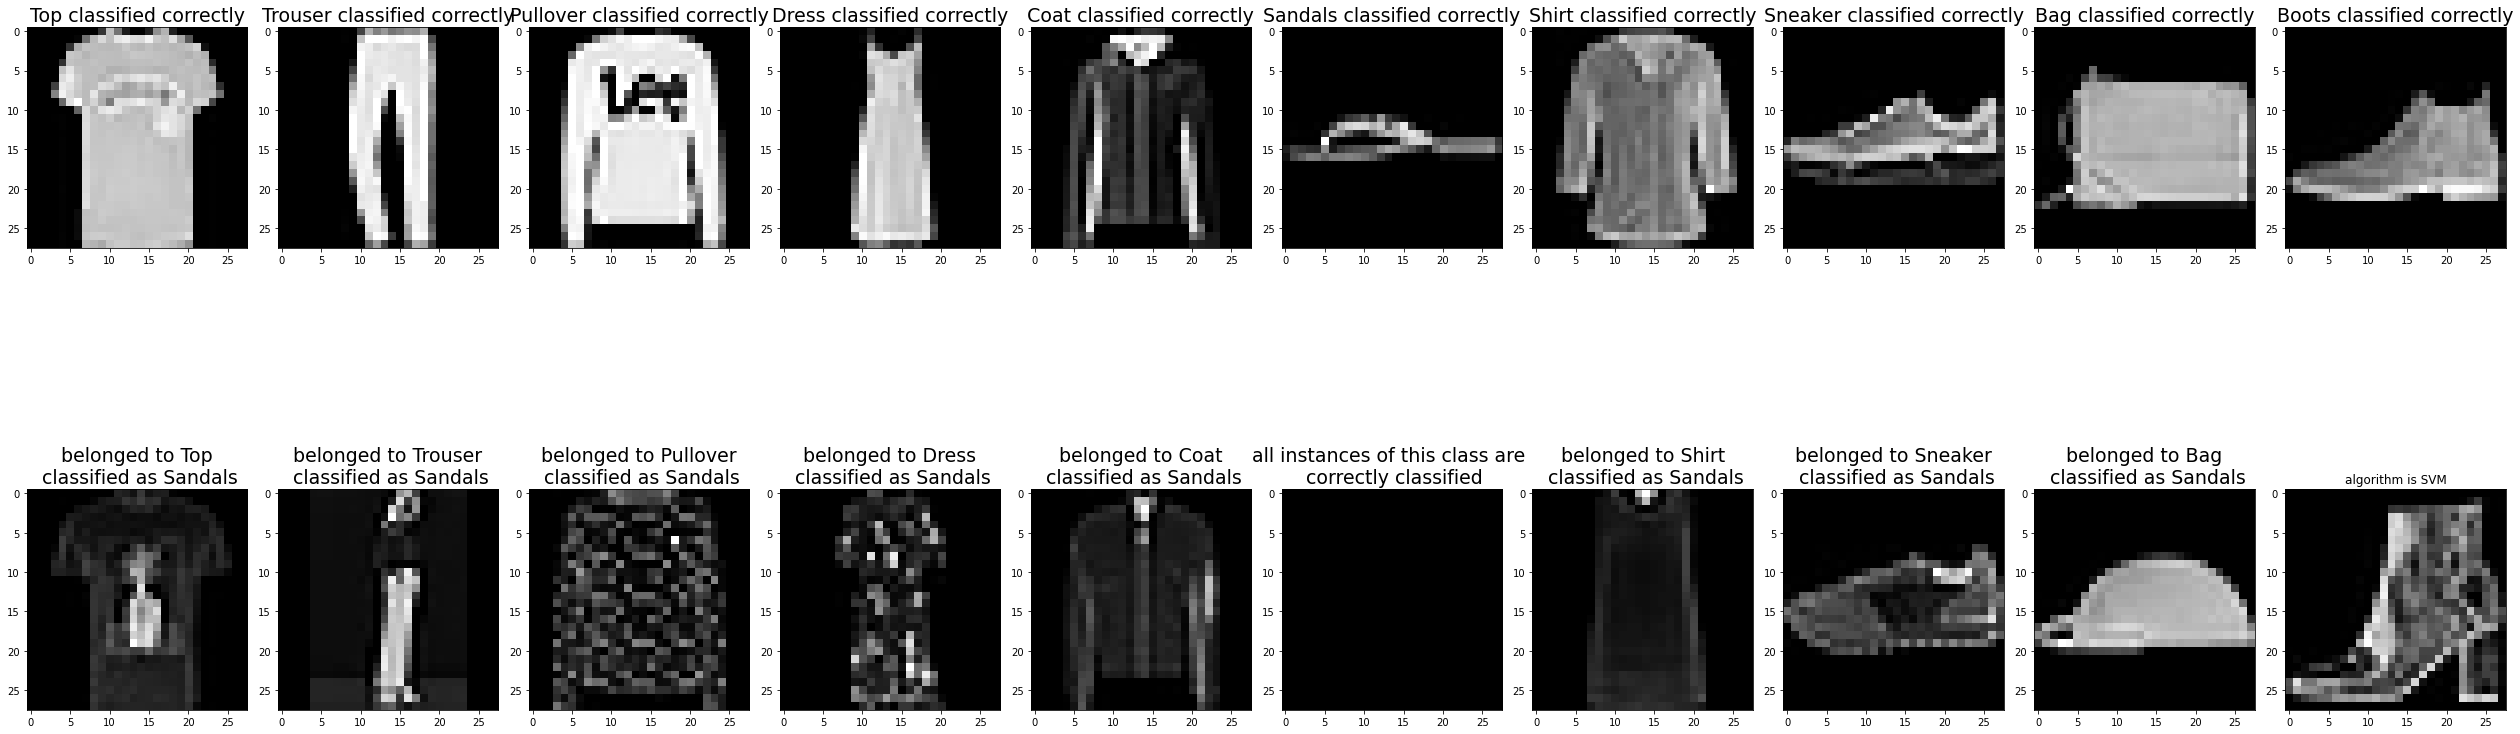

In [96]:
inc_inst_svm, corr_inst_svm, incorr_inst_svm = get_correct_and_incorrect_instances(max_acc_svm_ind, predictions_svm)
plot_correct_and_incorrect_instances(inc_inst_svm, corr_inst_svm, incorr_inst_svm, algo='SVM')

In [97]:
# sorting svm accs indeces

idx_acc_sorted_svm = sorted(range(len(accs_svm)),key=accs_svm.__getitem__)

In [98]:
# preparing sorted list

accs_sorted_svm = []
svm_sorted = []

for i in range(len(accs_svm)):
    accs_sorted_svm.append(accs_svm[idx_acc_sorted_svm[i]])
    svm_sorted.append(svcs[idx_acc_sorted_svm[i]])

In [99]:
# getting svm objects parameters

params_all_svm = []

for i in range(len(svm_sorted)):
    params = str(svm_sorted[i].get_params)
    params = params[params.find("(")+1:params.find(")")]
    params_all_svm.append(params)



In [100]:
# now getting optimal svm object

optimal_svm = svm_sorted[-1]

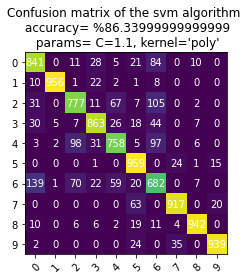

In [101]:
confusion_matrix_optimal_svm = confusion_matrix(test_labels, predictions_svm[max_acc_svm_ind])

draw_conf_matrix(confusion_matrix_optimal_svm, accs_sorted_svm[-1], algo='svm', params=params_all_svm[-1])

Text(0.5, 1.0, 'SVM accuracies with adjusted hyperparameters plotted')

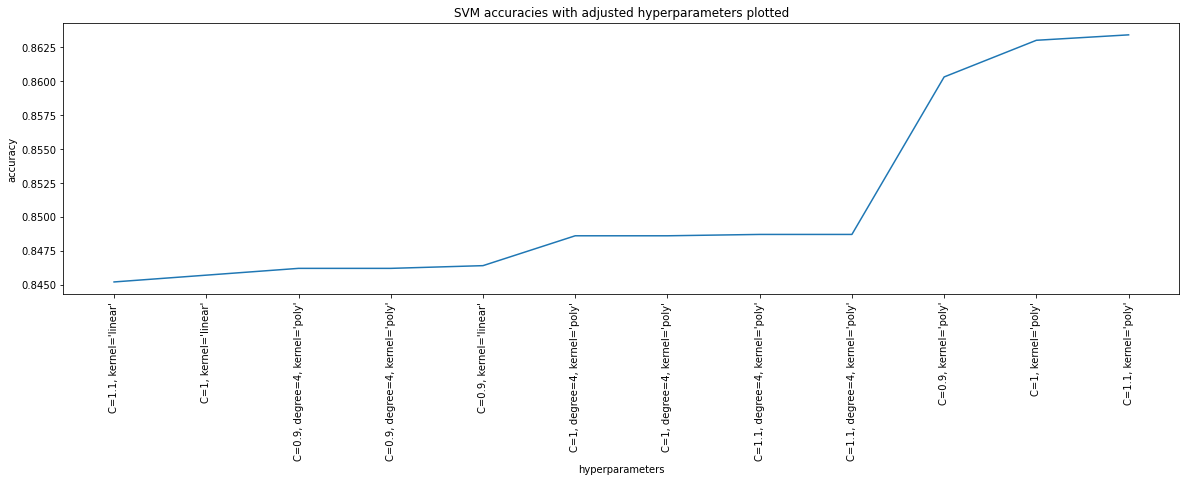

In [102]:
# plotting svm objects with ordered accuracies

plt.figure(figsize=(20, 5))
plt.plot(np.arange(len(accs_sorted_svm)), accs_sorted_svm)
plt.xticks(np.arange(len(params_all_svm)), params_all_svm, rotation= 90)
plt.xlabel('hyperparameters')
plt.ylabel('accuracy')
plt.title('SVM accuracies with adjusted hyperparameters plotted')

In [103]:
# initializing Decision tree classifier

from sklearn.tree import DecisionTreeClassifier


criterions = ['entropy'] # initially tested with gini as well did not give desired performance
splitters = ['random'] # random works better
max_depths = [10, 15, None]
min_samples_splits = [1.0, 2, 3]
min_samples_leafs = [1, 2, 3]
max_features = ['sqrt', 'log2'] # max features none does not yield the optimal results therefore i dropped it

decision_trees = []

for i in range(len(criterions)):
    for j in range(len(splitters)):
        for k in range(len(max_depths)):
            for l in range(len(min_samples_splits)):
                for x in range(len(min_samples_leafs)):
                    for y in range(len(max_features)):
                    
                        criterion = criterions[i]
                        splitter = splitters[j]
                        max_depth = max_depths[k]
                        min_samples_split = min_samples_splits[l]
                        min_samples_leaf = min_samples_leafs[x]
                        max_feature = max_features[y]
                        
                        decision_tree = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_feature)
                        decision_trees.append(decision_tree)

In [104]:
# fitting decision tree objects

start = time.time()
pass_time_decision_trees_fit = []

for i in range(len(decision_trees)):
    decision_trees[i].fit(scaled_train_images, train_labels)
    
    end = time.time()
    pass_time = end - start
    
    print('at iteration=',i, 'time passed in seconds is=', int(pass_time))
    pass_time_decision_trees_fit.append(pass_time)
    start= time.time()

at iteration= 0 time passed in seconds is= 0
at iteration= 1 time passed in seconds is= 0
at iteration= 2 time passed in seconds is= 0
at iteration= 3 time passed in seconds is= 0
at iteration= 4 time passed in seconds is= 0
at iteration= 5 time passed in seconds is= 0
at iteration= 6 time passed in seconds is= 0
at iteration= 7 time passed in seconds is= 0
at iteration= 8 time passed in seconds is= 0
at iteration= 9 time passed in seconds is= 0
at iteration= 10 time passed in seconds is= 0
at iteration= 11 time passed in seconds is= 0
at iteration= 12 time passed in seconds is= 0
at iteration= 13 time passed in seconds is= 0
at iteration= 14 time passed in seconds is= 0
at iteration= 15 time passed in seconds is= 0
at iteration= 16 time passed in seconds is= 0
at iteration= 17 time passed in seconds is= 0
at iteration= 18 time passed in seconds is= 0
at iteration= 19 time passed in seconds is= 0
at iteration= 20 time passed in seconds is= 0
at iteration= 21 time passed in seconds is= 

In [105]:
# predictions for each decision tree object

predictions_decision_tree = []
time_spend_decision_tree_predict = []
start = time.time()

for i in range(len(decision_trees)):
    prediction = decision_trees[i].predict(scaled_test_images)
    end = time.time()
    pass_time = end - start
    
    predictions_decision_tree.append(prediction)
    time_spend_decision_tree_predict.append(pass_time)
    print('at iteration', i, 'passed seconds= ', pass_time)
    start = time.time()

at iteration 0 passed seconds=  0.04303312301635742
at iteration 1 passed seconds=  0.024975299835205078
at iteration 2 passed seconds=  0.024973630905151367
at iteration 3 passed seconds=  0.02597188949584961
at iteration 4 passed seconds=  0.0339055061340332
at iteration 5 passed seconds=  0.025975704193115234
at iteration 6 passed seconds=  0.02797079086303711
at iteration 7 passed seconds=  0.027968406677246094
at iteration 8 passed seconds=  0.02775263786315918
at iteration 9 passed seconds=  0.026971817016601562
at iteration 10 passed seconds=  0.03096771240234375
at iteration 11 passed seconds=  0.029970169067382812
at iteration 12 passed seconds=  0.028971433639526367
at iteration 13 passed seconds=  0.025969743728637695
at iteration 14 passed seconds=  0.02497577667236328
at iteration 15 passed seconds=  0.025973796844482422
at iteration 16 passed seconds=  0.025972604751586914
at iteration 17 passed seconds=  0.025973081588745117
at iteration 18 passed seconds=  0.02597284317

In [106]:
# getting accuracy scores for the decision tree objects

accs_decision_tree = []

max_acc_decision_tree = 0
max_acc_decision_tree_ind = 0

for i in range(len(predictions_decision_tree)):
    
    score = accuracy_score(test_labels, predictions_decision_tree[i])
    
    if score > max_acc_decision_tree:
        max_acc_decision_tree = score
        max_acc_decision_tree_ind = i
        
    accs_decision_tree.append(score)


<Figure size 432x288 with 0 Axes>

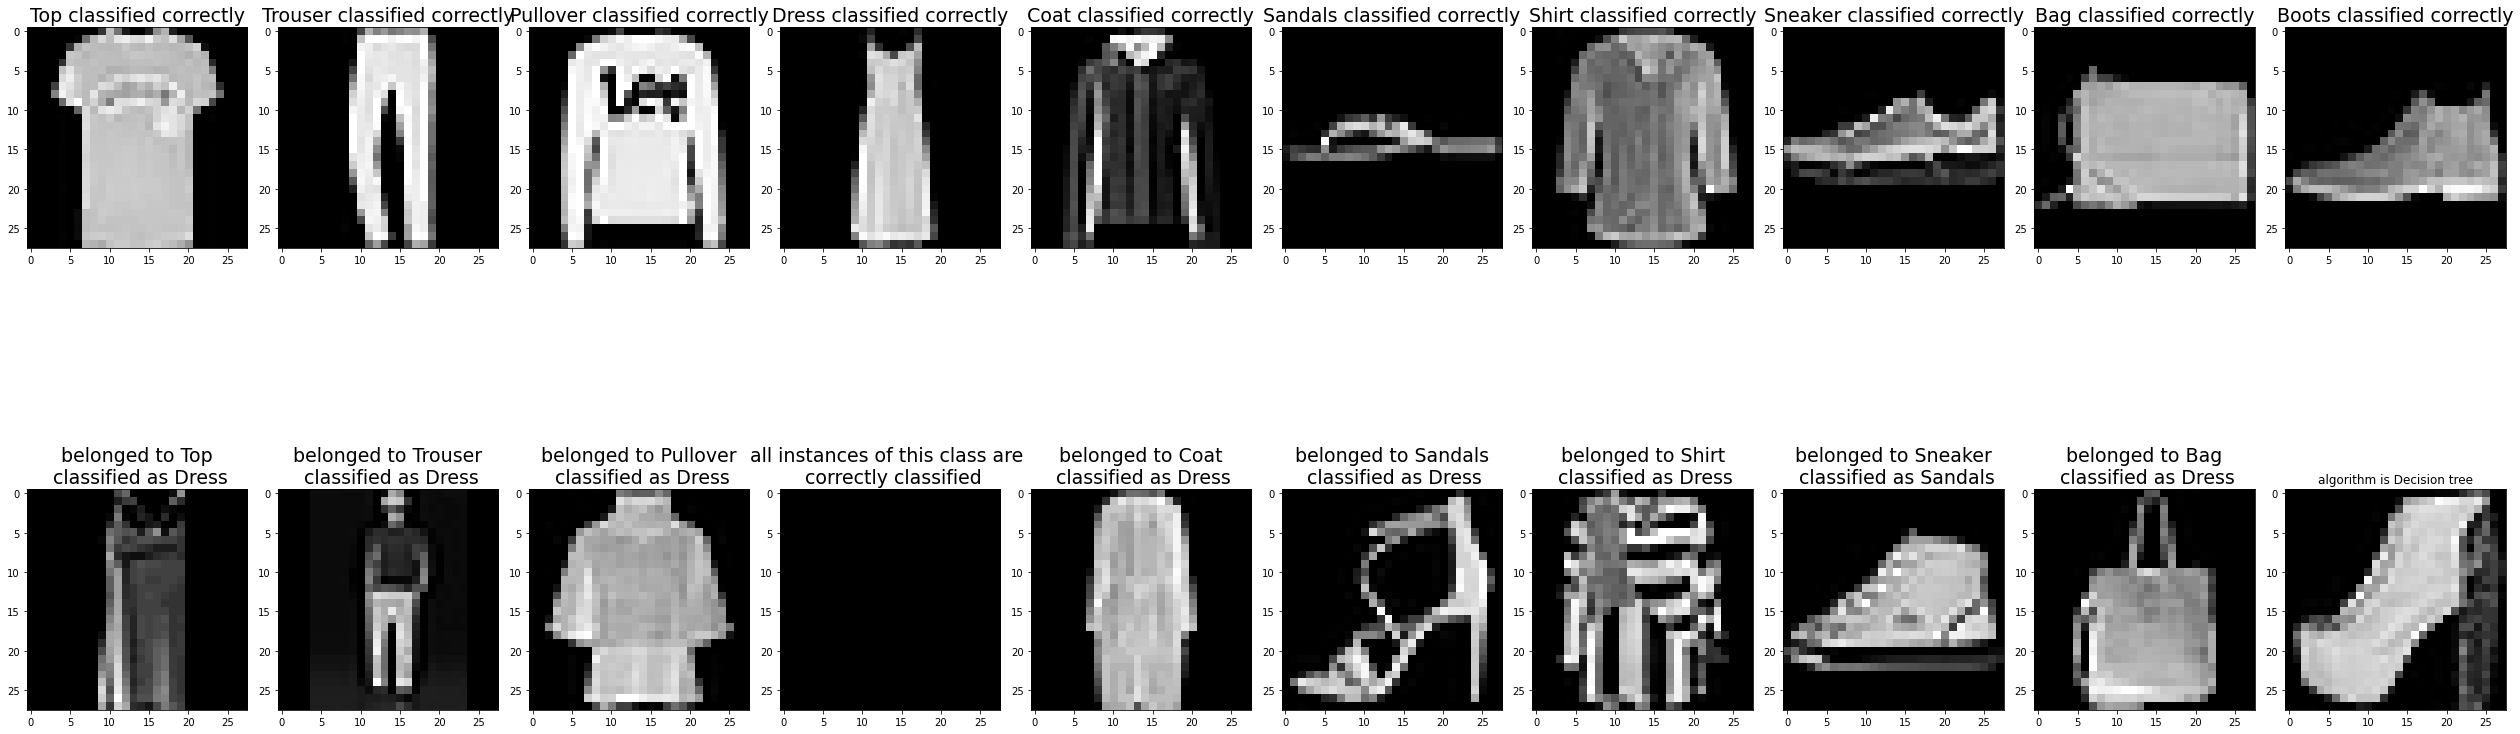

In [107]:
inc_inst_des, corr_inst_des, incorr_inst_des = get_correct_and_incorrect_instances(max_acc_decision_tree_ind, predictions_decision_tree)
plot_correct_and_incorrect_instances(inc_inst_des, corr_inst_des, incorr_inst_des, algo='Decision tree')

In [108]:
# sorting decision tree accs indeces

idx_acc_sorted_decision_tree = sorted(range(len(accs_decision_tree)),key=accs_decision_tree.__getitem__)

In [109]:
# preparing sorted list

accs_sorted_decision_tree = []
decision_tree_sorted = []

for i in range(len(decision_trees)):
    accs_sorted_decision_tree.append(accs_decision_tree[idx_acc_sorted_decision_tree[i]])
    decision_tree_sorted.append(decision_trees[idx_acc_sorted_decision_tree[i]])

In [110]:
# getting decision tree objects parameters

params_all_decision_tree = []

for i in range(len(decision_tree_sorted)):
    params = str(decision_tree_sorted[i].get_params)
    params = params[params.find("(")+1:params.find(")")]
    params_all_decision_tree.append(params)



Text(0.5, 1.0, 'Decision tree accuracies with adjusted hyperparameters plotted')

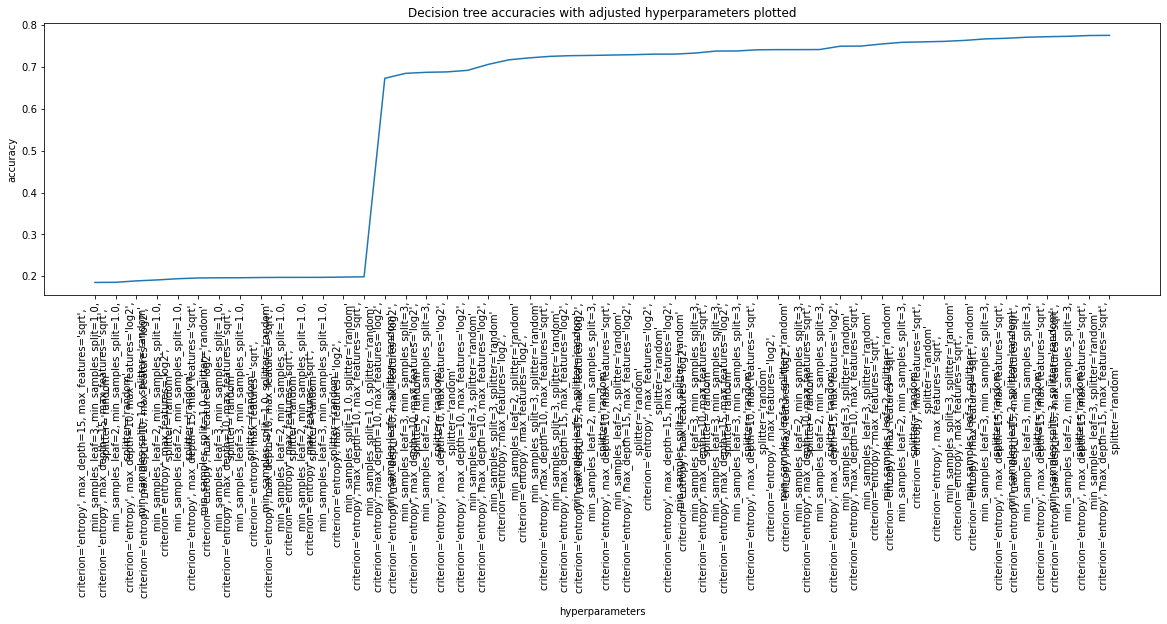

In [111]:
# plotting highest 50 accuracy decision tree objects 

plt.figure(figsize=(20, 5))
plt.plot(np.arange(50), accs_sorted_decision_tree[-50:])
plt.xticks(np.arange(50), params_all_decision_tree[-50:], rotation= 90)
plt.xlabel('hyperparameters')
plt.ylabel('accuracy')
plt.title('Decision tree accuracies with adjusted hyperparameters plotted')

In [112]:
# getting optimal decision tree

optimal_decision_tree = decision_tree_sorted[-1]
optimal_decision_tree

DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       splitter='random')

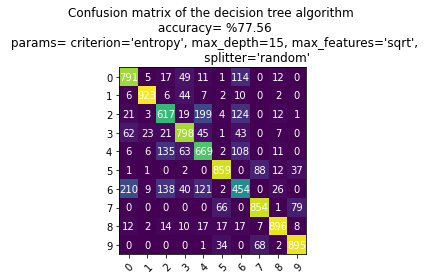

In [113]:
# getting the confusion matrix of the optimal decision tree classifier 


confusion_matrix_optimal_decision_tree = confusion_matrix(test_labels, predictions_decision_tree[max_acc_decision_tree_ind])

draw_conf_matrix(confusion_matrix_optimal_decision_tree, accs_sorted_decision_tree[-1], algo='decision tree', params=params_all_decision_tree[-1])

In [114]:
# initializing random forest classifiers

from sklearn.ensemble import RandomForestClassifier


# initializing hyperparameters to be tuned

n_estimators_ = [50, 100]
criterions = ['entropy'] # I initially test with gini but entropy worked better for timing constraints I dropped it
max_depths = [10, None]
min_samples_splits = [1.0, 2, 3]
min_samples_leafs = [1, 2, 3]
max_features_ = ['sqrt', 'log2'] # Initially tested with none did not give good results

random_forest_classifiers = []

for i in range(len(n_estimators_)):
    for j in range(len(criterions)):
        for k in range(len(max_depths)):
            for l in range(len(min_samples_splits)):
                for x in range(len(min_samples_leafs)):
                    for y in range(len(max_features_)):
                        n_estimators = n_estimators_[i]
                        criterion = criterions[j]
                        max_depth = max_depths[k]
                        min_samples_split = min_samples_splits[l]
                        min_samples_leaf = min_samples_leafs[x]
                        max_features = max_features_[y]
                        random_forest_classfier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features)
                        random_forest_classifiers.append(random_forest_classfier)
                        
len(random_forest_classifiers)

72

In [115]:
# fitting random forest objects

start = time.time()
pass_time_random_forest_fit = []

for i in range(len(random_forest_classifiers)):
    random_forest_classifiers[i].fit(scaled_train_images, train_labels)
    
    end = time.time()
    pass_time = end - start
    
    print('at iteration=',i, 'time passed in seconds is=', int(pass_time))
    pass_time_random_forest_fit.append(pass_time)
    start= time.time()

at iteration= 0 time passed in seconds is= 0
at iteration= 1 time passed in seconds is= 0
at iteration= 2 time passed in seconds is= 0
at iteration= 3 time passed in seconds is= 0
at iteration= 4 time passed in seconds is= 0
at iteration= 5 time passed in seconds is= 0
at iteration= 6 time passed in seconds is= 31
at iteration= 7 time passed in seconds is= 11
at iteration= 8 time passed in seconds is= 31
at iteration= 9 time passed in seconds is= 11
at iteration= 10 time passed in seconds is= 31
at iteration= 11 time passed in seconds is= 11
at iteration= 12 time passed in seconds is= 31
at iteration= 13 time passed in seconds is= 11
at iteration= 14 time passed in seconds is= 32
at iteration= 15 time passed in seconds is= 11
at iteration= 16 time passed in seconds is= 31
at iteration= 17 time passed in seconds is= 10
at iteration= 18 time passed in seconds is= 0
at iteration= 19 time passed in seconds is= 0
at iteration= 20 time passed in seconds is= 0
at iteration= 21 time passed in 

In [116]:
# predictions for each random forest object

predictions_random_forest = []
time_spend_random_forest_predict = []
start = time.time()

for i in range(len(random_forest_classifiers)):
    prediction = random_forest_classifiers[i].predict(scaled_test_images)
    end = time.time()
    pass_time = end - start
    
    predictions_random_forest.append(prediction)
    time_spend_random_forest_predict.append(pass_time)
    print('at iteration', i, 'passed seconds= ', pass_time)
    start = time.time()

at iteration 0 passed seconds=  0.5065150260925293
at iteration 1 passed seconds=  0.08491158485412598
at iteration 2 passed seconds=  0.08491206169128418
at iteration 3 passed seconds=  0.08890533447265625
at iteration 4 passed seconds=  0.08891654014587402
at iteration 5 passed seconds=  0.08630084991455078
at iteration 6 passed seconds=  0.22200846672058105
at iteration 7 passed seconds=  0.22176432609558105
at iteration 8 passed seconds=  0.21320343017578125
at iteration 9 passed seconds=  0.2169644832611084
at iteration 10 passed seconds=  0.2139594554901123
at iteration 11 passed seconds=  0.2110888957977295
at iteration 12 passed seconds=  0.22783875465393066
at iteration 13 passed seconds=  0.25572943687438965
at iteration 14 passed seconds=  0.22676849365234375
at iteration 15 passed seconds=  0.206787109375
at iteration 16 passed seconds=  0.23974943161010742
at iteration 17 passed seconds=  0.23575472831726074
at iteration 18 passed seconds=  0.08691120147705078
at iteration

In [117]:
# getting accuracy scores for the random forest objects

accs_random_forest = []

max_acc_random_forest = 0
max_acc_random_forest_ind = 0

for i in range(len(predictions_random_forest)):
    
    score = accuracy_score(test_labels, predictions_random_forest[i])
    
    if score > max_acc_random_forest:
        max_acc_random_forest = score
        max_acc_random_forest_ind = i
        
    accs_random_forest.append(score)


<Figure size 432x288 with 0 Axes>

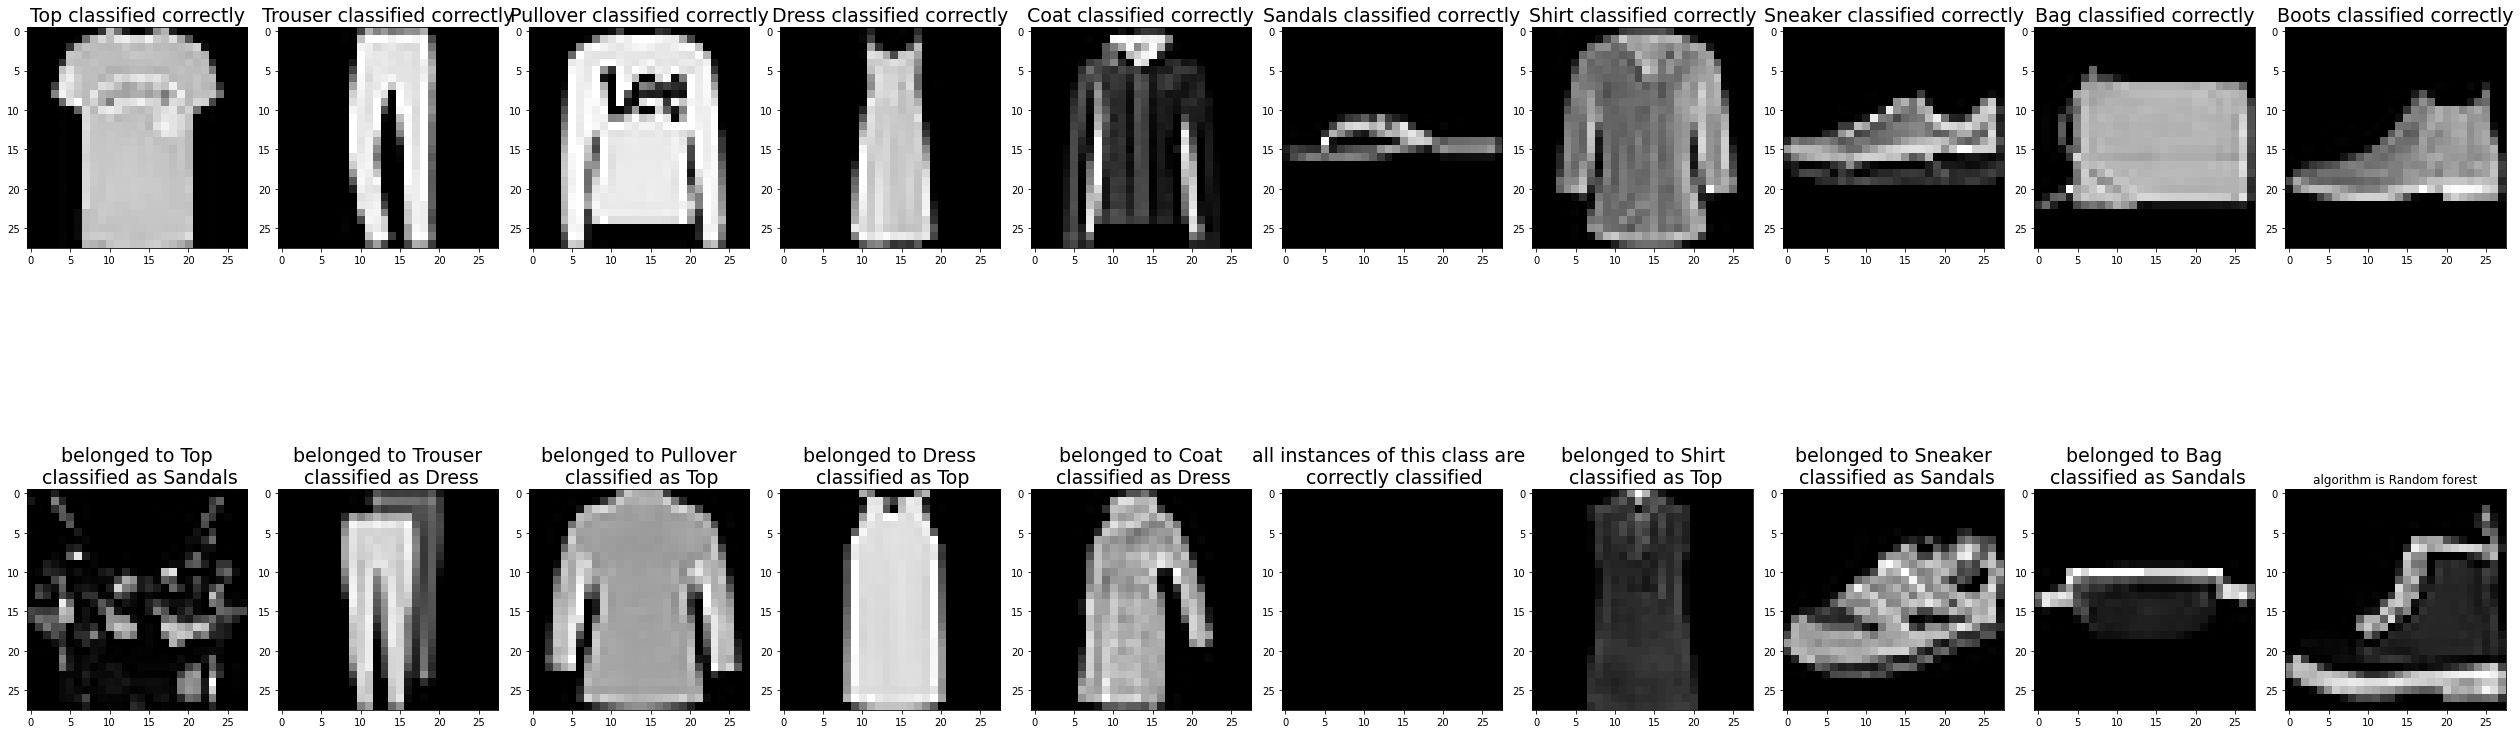

In [118]:
inc_inst_ran, corr_inst_ran, incorr_inst_ran = get_correct_and_incorrect_instances(max_acc_random_forest_ind, predictions_random_forest)
plot_correct_and_incorrect_instances(inc_inst_ran, corr_inst_ran, incorr_inst_ran, algo='Random forest')

In [119]:
# sorting random forest accs indeces

idx_acc_sorted_random_forest = sorted(range(len(accs_random_forest)),key=accs_random_forest.__getitem__)

In [120]:
# preparing sorted list

accs_sorted_random_forest = []
random_forest_sorted = []

for i in range(len(accs_random_forest)):
    accs_sorted_random_forest.append(accs_random_forest[idx_acc_sorted_random_forest[i]])
    random_forest_sorted.append(random_forest_classifiers[idx_acc_sorted_random_forest[i]])

In [121]:
# getting random forest objects parameters

params_all_random_forest = []

for i in range(len(random_forest_sorted)):
    params = str(random_forest_sorted[i].get_params)
    params = params[params.find("(")+1:params.find(")")]
    params_all_random_forest.append(params)



Text(0.5, 1.0, 'Random forest accuracies with adjusted hyperparameters plotted')

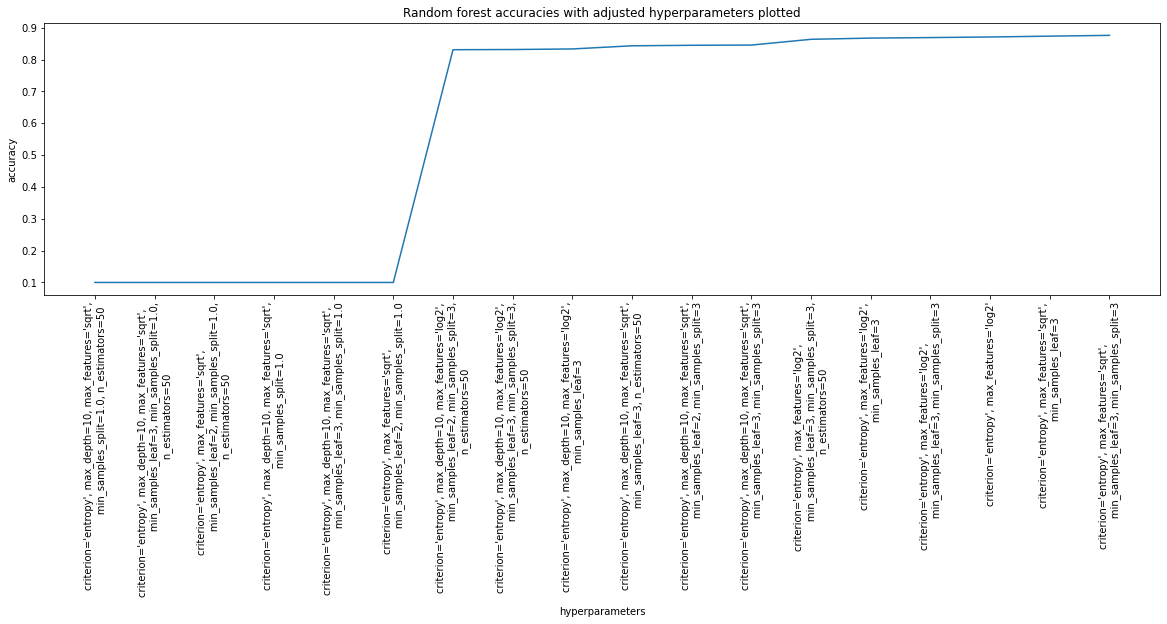

In [122]:
# plotting every four random forest objects to see the effect of hyperparameters

plt.figure(figsize=(20, 5))
plt.plot(np.arange(len(accs_sorted_random_forest)/4), accs_sorted_random_forest[::4])
plt.xticks(np.arange(len(params_all_random_forest)/4), params_all_random_forest[::4], rotation= 90)
plt.xlabel('hyperparameters')
plt.ylabel('accuracy')
plt.title('Random forest accuracies with adjusted hyperparameters plotted')

In [123]:
# getting optimal random forest object

optimal_random_forest = random_forest_sorted[-1]
optimal_random_forest

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=2)

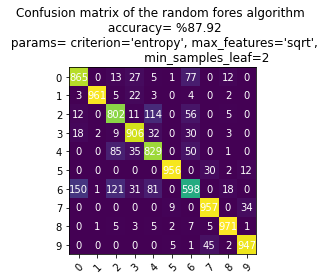

In [124]:
confusion_matrix_optimal_random_forest = confusion_matrix(test_labels, predictions_random_forest[max_acc_random_forest_ind])

draw_conf_matrix(confusion_matrix_optimal_random_forest, accs_sorted_random_forest[-1], algo='random forest', params=params_all_random_forest[-1])

In [125]:
# initializing pca objects


from sklearn.decomposition import PCA

pca_n_components = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 160]


pcas = []


for i in range(len(pca_n_components)):
    pca = PCA(n_components=pca_n_components[i])
    pcas.append(pca)

In [126]:
# fitting pca models

scaled_train_images_pca_applied = []
scaled_test_images_pca_applied = []


for i in range(len(pcas)):
    pca_applied = pcas[i].fit_transform(scaled_train_images)
    scaled_train_images_pca_applied.append(pca_applied)
    
    pca_applied_test = pcas[i].transform(scaled_test_images)
    scaled_test_images_pca_applied.append(pca_applied_test)

In [127]:
# getting explained variance for each pca object

pcas_explained_variances = []

for i in range(len(pcas)):
    exp_var = pcas[i].explained_variance_ratio_
    sum_exp_var = sum(exp_var)
    pcas_explained_variances.append(sum_exp_var)
    
pcas_explained_variances

[0.290315460334912,
 0.46783353983252896,
 0.5280173390542354,
 0.577583867645074,
 0.6160502635735244,
 0.7197578729136571,
 0.7591459353016539,
 0.784943469613691,
 0.8045312391295192,
 0.8205756351781665,
 0.833631808509886,
 0.8448315097855631,
 0.8542984950040037,
 0.8625148781288612,
 0.8697690811655402,
 0.8762998886488035,
 0.8821618759230804,
 0.8876312823356054,
 0.9405997450581348]

Text(0.5, 1.0, 'Number of components with explained variances')

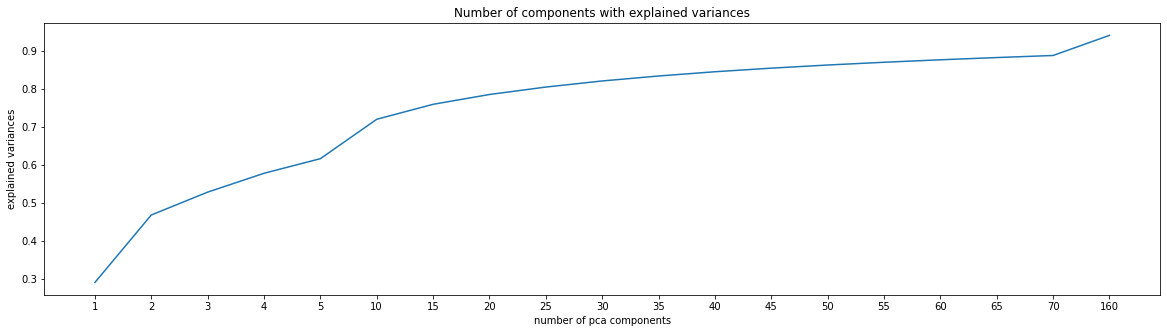

In [128]:
# plotting explained variances and number of pca components

plt.figure(figsize=(20, 5))
plt.plot(np.arange(len(pcas)), pcas_explained_variances)
plt.xticks(np.arange(len(pcas)), pca_n_components)
plt.xlabel('number of pca components')
plt.ylabel('explained variances')
plt.title('Number of components with explained variances')

In [129]:
# finding closest expalined variances for each explained variance step e.g. 25, 50, 75, 95

desired_variances = [0.25, 0.50, 0.75, 0.95]

num_components_for_desired_variances = []

for i in range(len(desired_variances)):
    closest_pca_n_components = min(pcas_explained_variances, key=lambda x:abs(x-desired_variances[i]))
    ind = pcas_explained_variances.index(closest_pca_n_components)
    num_components_for_desired_variances.append(ind)
    
num_components_for_desired_variances

[0, 2, 6, 18]

In [130]:
# getting the number of components for each desired explained variance

des_num_comps_pca = []

for i in range(len(num_components_for_desired_variances)):
    des_num_comps_pca.append(pca_n_components[num_components_for_desired_variances[i]])

In [131]:
# getting the desired pca objects for each wanted explained variances

desired_scaled_train_images = []
desired_scaled_test_images = []

for i in range(len(num_components_for_desired_variances)):

    num_components = num_components_for_desired_variances[i]
    
    desired_scaled_train_image = scaled_train_images_pca_applied[num_components]
    desired_scaled_test_image = scaled_test_images_pca_applied[num_components]

    
    desired_scaled_train_images.append(desired_scaled_train_image)
    desired_scaled_test_images.append(desired_scaled_test_image)

In [132]:
# now initializing the algorithms with optimal parameters found on the earlier steps 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron

optimal_knns_pcas = []
optimal_perceptrons_pcas = []
optimal_svms_pcas = []
optimal_decision_trees_pcas = []
optimal_random_forests_pcas = []

for i in range(4):
    knn = KNeighborsClassifier(n_neighbors=25, weights='distance', algorithm='kd_tree', p=1)
    perceptron = Perceptron(fit_intercept=False, tol=.0005)
    svm = SVC(C=1.1, kernel='poly')
    decision_tree = DecisionTreeClassifier(criterion='entropy', splitter='random', max_depth=10, min_samples_split=3, min_samples_leaf=3)
    random_forest = RandomForestClassifier(n_estimators=50, criterion='entropy', min_samples_split=3, min_samples_leaf=3, max_features='sqrt')
    
    optimal_knns_pcas.append(knn)
    optimal_perceptrons_pcas.append(perceptron)
    optimal_svms_pcas.append(svm)
    optimal_decision_trees_pcas.append(decision_tree)
    optimal_random_forests_pcas.append(random_forest)

In [133]:
optimal_perceptrons_pcas[0].get_params

<bound method BaseEstimator.get_params of Perceptron(fit_intercept=False, tol=0.0005)>

In [134]:
# fitting optimal algorithms for each desired explained variances
import time

init = time.time()

pca_spend_time_fit_knn = []
pca_spend_time_fit_svm = []
pca_spend_time_fit_perceptron = []
pca_spend_time_fit_decision_trees = []
pca_spend_time_fit_random_forest = []


for i in range(4):
    
    start_i = time.time()
    
    start= time.time()
    optimal_knns_pcas[i].fit(desired_scaled_train_images[i], train_labels)
    end = time.time()
    pass_time = end - start
    pca_spend_time_fit_knn.append(pass_time)
    print('knn at iteration=', i, 'time passed in seconds is=', int(pass_time), 'params=', str(optimal_knns_pcas[i].get_params))
    
    start= time.time()
    optimal_perceptrons_pcas[i].fit(desired_scaled_train_images[i], train_labels)
    end = time.time()
    pass_time = end - start
    pca_spend_time_fit_perceptron.append(pass_time)
    print('perceptron at iteration=', i, 'time passed in seconds is=', int(pass_time), 'params=', str(optimal_perceptrons_pcas[i].get_params))
    
    start= time.time()
    optimal_svms_pcas[i].fit(desired_scaled_train_images[i], train_labels)
    end = time.time()
    pass_time = end - start
    pca_spend_time_fit_svm.append(pass_time)
    print('svm at iteration=', i, 'time passed in seconds is=', int(pass_time), 'params=', str(optimal_svms_pcas[i].get_params))
    
    start= time.time()
    optimal_decision_trees_pcas[i].fit(desired_scaled_train_images[i], train_labels)
    end = time.time()
    pass_time = end - start
    pca_spend_time_fit_decision_trees.append(pass_time)
    print('decision tree at iteration=', i, 'time passed in seconds is=', int(pass_time), 'params=', str(optimal_decision_trees_pcas[i].get_params))
    
    start= time.time()
    optimal_random_forests_pcas[i].fit(desired_scaled_train_images[i], train_labels)
    end = time.time()
    pass_time = end - start
    pca_spend_time_fit_random_forest.append(pass_time)
    print('random forest at iteration=', i, 'time passed in seconds is=', int(pass_time), 'params=', str(optimal_random_forests_pcas[i].get_params))
    
    end = time.time()
    pass_time_iter = end - start_i
    print('iteration',i,'completed, total time spend in seconds', int(pass_time_iter))
    
end_ = time.time()

print('time spend for completing all the iterations= ' + str(int(end_ - init)))


knn at iteration= 0 time passed in seconds is= 0 params= <bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='kd_tree', n_neighbors=25, p=1,
                     weights='distance')>
perceptron at iteration= 0 time passed in seconds is= 0 params= <bound method BaseEstimator.get_params of Perceptron(fit_intercept=False, tol=0.0005)>
svm at iteration= 0 time passed in seconds is= 163 params= <bound method BaseEstimator.get_params of SVC(C=1.1, kernel='poly')>
decision tree at iteration= 0 time passed in seconds is= 0 params= <bound method BaseEstimator.get_params of DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,
                       min_samples_split=3, splitter='random')>
random forest at iteration= 0 time passed in seconds is= 16 params= <bound method BaseEstimator.get_params of RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=3,
                       n_es

In [135]:
# predicting with optimal algorithms for each desired explained variance

optimal_knn_pca_preds = []
optimal_perceptron_pca_preds = []
optimal_svm_pca_preds = []
optimal_decision_tree_pca_preds = []
optimal_random_forest_pca_preds = []

for i in range(4):
    
    optimal_knn_pca_preds.append(optimal_knns_pcas[i].predict(desired_scaled_test_images[i]))
    optimal_perceptron_pca_preds.append(optimal_perceptrons_pcas[i].predict(desired_scaled_test_images[i]))
    optimal_svm_pca_preds.append(optimal_svms_pcas[i].predict(desired_scaled_test_images[i]))
    optimal_decision_tree_pca_preds.append(optimal_decision_trees_pcas[i].predict(desired_scaled_test_images[i]))
    optimal_random_forest_pca_preds.append(optimal_random_forests_pcas[i].predict(desired_scaled_test_images[i]))


In [136]:
# getting the accuracy score and confusion matrix of each object

from sklearn.metrics import accuracy_score

optimal_knn_pca_accs = []
optimal_perceptron_pca_accs = []
optimal_svm_pca_accs = []
optimal_decision_tree_pca_accs = []
optimal_random_forest_pca_accs = []


for i in range(4):
    
    score_knn = accuracy_score(test_labels, optimal_knn_pca_preds[i])
    score_perceptron = accuracy_score(test_labels, optimal_perceptron_pca_preds[i])
    score_svm = accuracy_score(test_labels, optimal_svm_pca_preds[i])
    score_decision_tree = accuracy_score(test_labels, optimal_decision_tree_pca_preds[i])
    score_random_forest = accuracy_score(test_labels, optimal_random_forest_pca_preds[i])
        
    optimal_knn_pca_accs.append(score_knn)
    optimal_perceptron_pca_accs.append(score_perceptron)
    optimal_svm_pca_accs.append(score_svm)
    optimal_decision_tree_pca_accs.append(score_decision_tree)
    optimal_random_forest_pca_accs.append(score_random_forest)


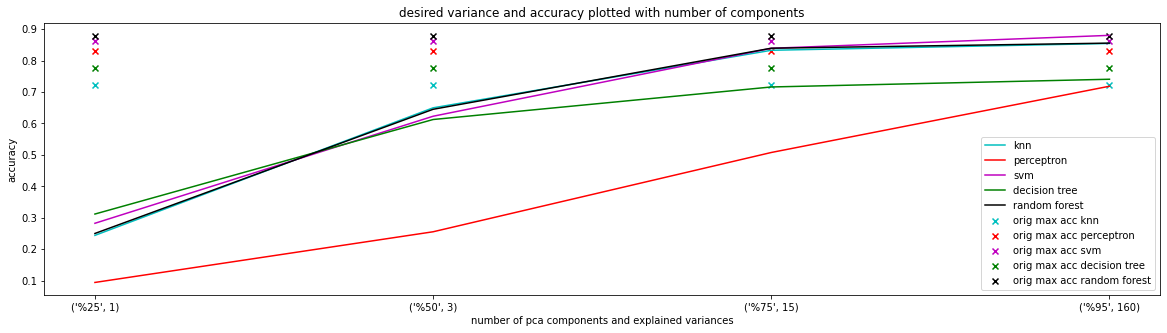

In [152]:
# plotting accuracy of each algorithm with original accuracy marked

opt_acc_knn_orig = [max_score_knn, max_score_knn, max_score_knn, max_score_knn]
opt_acc_perc_orig = [max_acc_perceptron, max_acc_perceptron, max_acc_perceptron, max_acc_perceptron]
opt_acc_svm_orig = [max_acc_svm, max_acc_svm, max_acc_svm, max_acc_svm]
opt_acc_decision_tree_orig = [max_acc_decision_tree,max_acc_decision_tree, max_acc_decision_tree,max_acc_decision_tree]
opt_acc_random_forest_orig = [max_acc_random_forest,max_acc_random_forest,max_acc_random_forest,max_acc_random_forest]


plt.figure(figsize=(20, 5))
plt.plot(np.arange(4), optimal_knn_pca_accs, label='knn', c='c')
plt.plot(np.arange(4), optimal_perceptron_pca_accs, label='perceptron', c='r')
plt.plot(np.arange(4), optimal_svm_pca_accs, label='svm', c='m')
plt.plot(np.arange(4), optimal_decision_tree_pca_accs, label='decision tree', c='g')
plt.plot(np.arange(4), optimal_random_forest_pca_accs, label='random forest', c='k')
plt.scatter(np.arange(4), opt_acc_knn_orig, label='orig max acc knn', c='c', marker= 'x')
plt.scatter(np.arange(4), opt_acc_perc_orig, label= 'orig max acc perceptron', c='r', marker= 'x')
plt.scatter(np.arange(4), opt_acc_svm_orig, label= 'orig max acc svm', c='m', marker= 'x')
plt.scatter(np.arange(4), opt_acc_decision_tree_orig, label= 'orig max acc decision tree', c='g', marker= 'x')
plt.scatter(np.arange(4), opt_acc_random_forest_orig, label= 'orig max acc random forest', c='k', marker= 'x')

plt.xticks(np.arange(4), zip(desired_variances, des_num_comps_pca))
plt.xlabel('number of pca components and explained variances')
plt.ylabel('accuracy')
plt.title('desired variance and accuracy plotted with number of components')
plt.legend()


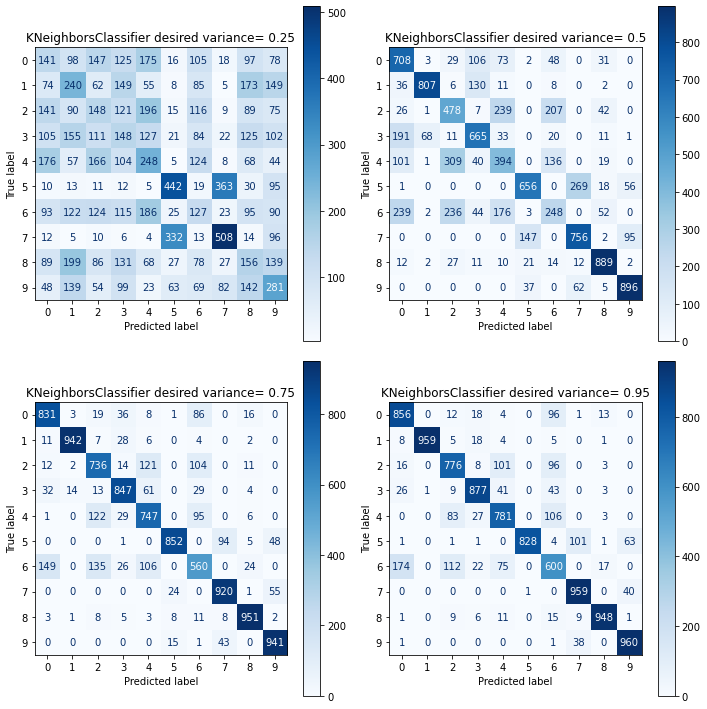

In [139]:
# now drawing confusion matrix for knn pca objects

from sklearn.metrics import plot_confusion_matrix


class_names = [0,1,2,3,4,5,6,7,8,9]


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

i = 0
for cls, ax in zip(optimal_knns_pcas, axes.flatten()):

    plot_confusion_matrix(cls, 
                          desired_scaled_test_images[i], 
                          test_labels, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=class_names)
                         
    ax.title.set_text(type(cls).__name__ + ' desired variance= ' + str(desired_variances[i]))
    
    i += 1
    
plt.tight_layout()  
plt.show()

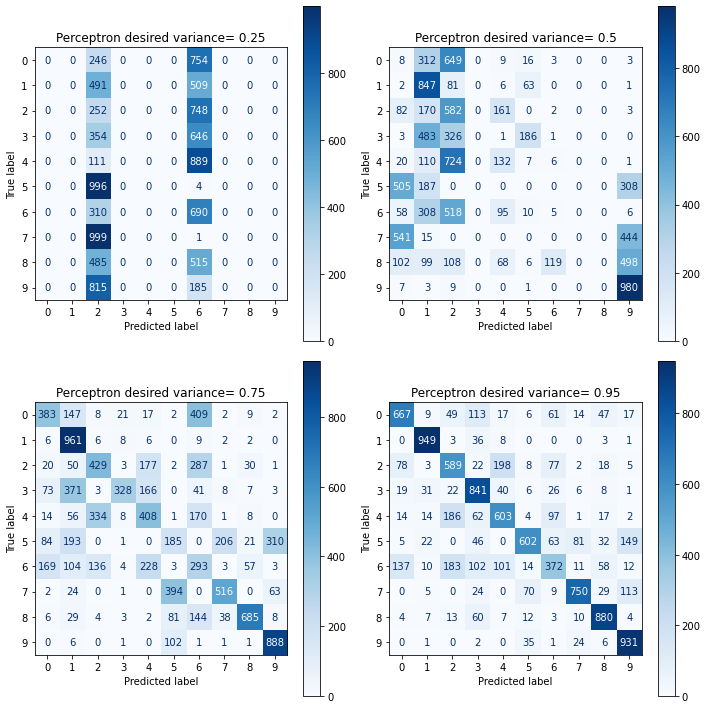

In [140]:
# now drawing confusion matrix for perceptron pca objects

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

i = 0
for cls, ax in zip(optimal_perceptrons_pcas, axes.flatten()):

    plot_confusion_matrix(cls, 
                          desired_scaled_test_images[i], 
                          test_labels, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=class_names)
                         
    ax.title.set_text(type(cls).__name__ + ' desired variance= ' + str(desired_variances[i]))
    
    i += 1
    
plt.tight_layout()  
plt.show()

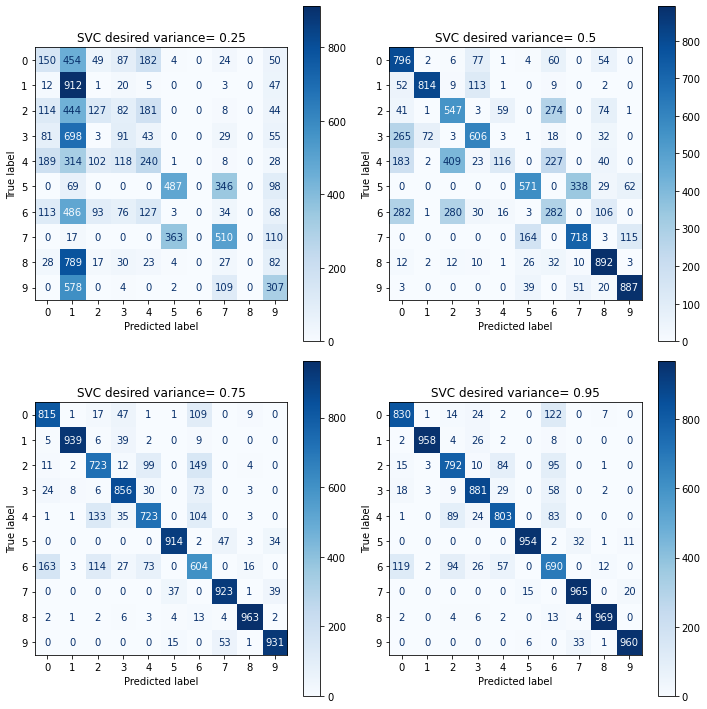

In [141]:
# now drawing confusion matrix for svm pca objects

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

i = 0
for cls, ax in zip(optimal_svms_pcas, axes.flatten()):

    plot_confusion_matrix(cls, 
                          desired_scaled_test_images[i], 
                          test_labels, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=class_names)
                         
    ax.title.set_text(type(cls).__name__ + ' desired variance= ' + str(desired_variances[i]))
    
    i += 1
    
plt.tight_layout()  
plt.show()

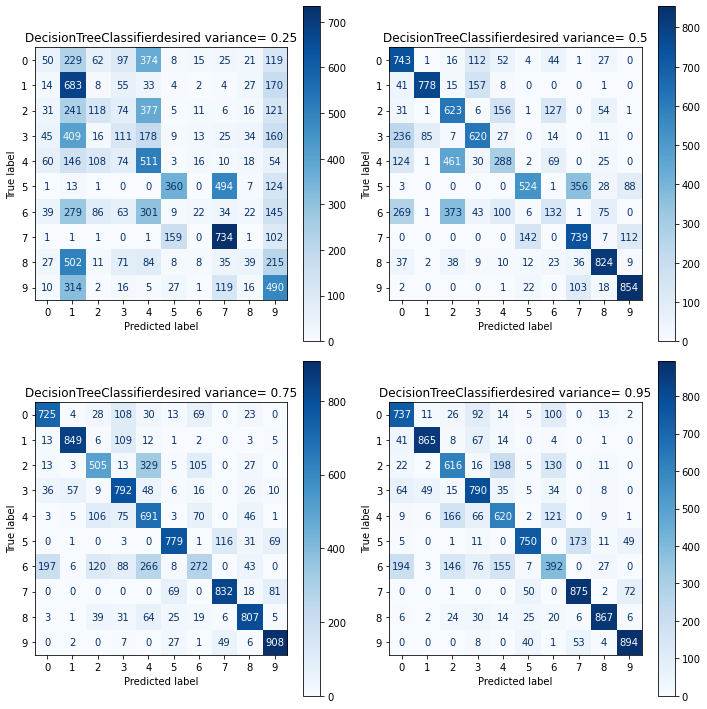

In [142]:
# now drawing confusion matrix for decision tree pca objects

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

i = 0
for cls, ax in zip(optimal_decision_trees_pcas, axes.flatten()):

    plot_confusion_matrix(cls, 
                          desired_scaled_test_images[i], 
                          test_labels, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=class_names)
                         
    ax.title.set_text(type(cls).__name__ + 'desired variance= ' + str(desired_variances[i]))
    
    i += 1
plt.tight_layout()  
plt.show()

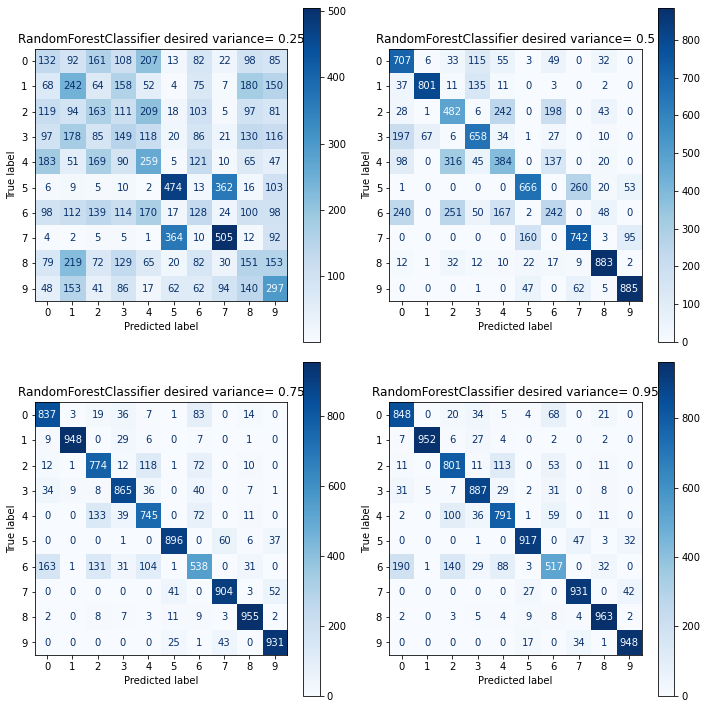

In [143]:
# now drawing confusion matrix for random forest pca objects

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

i = 0
for cls, ax in zip(optimal_random_forests_pcas, axes.flatten()):

    plot_confusion_matrix(cls, 
                          desired_scaled_test_images[i], 
                          test_labels, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=class_names)
                         
    ax.title.set_text(type(cls).__name__ + ' desired variance= ' + str(desired_variances[i]))
    
    i += 1
    
plt.tight_layout()  
plt.show()

In [144]:
# putting pca objects into pandas dataframe

import pandas as pd

desired_variances = ['%25', '%50', '%75', '%95'] 


df = pd.DataFrame()

df['classifier'] = ['knn','knn','knn','knn', 'perceptron', 'perceptron','perceptron','perceptron', 
                   'svm', 'svm', 'svm', 'svm', 'decision tree', 'decision tree', 'decision tree', 'decision tree', 
                   'random forest', 'random forest', 'random forest', 'random forest']


df['desired variances'] = desired_variances + desired_variances + desired_variances + desired_variances + desired_variances
df['pca # components'] = des_num_comps_pca + des_num_comps_pca + des_num_comps_pca + des_num_comps_pca + des_num_comps_pca
df['fitting time sec'] = pca_spend_time_fit_knn + pca_spend_time_fit_perceptron + pca_spend_time_fit_svm + pca_spend_time_fit_decision_trees + pca_spend_time_fit_random_forest
df['accuracy'] = optimal_knn_pca_accs + optimal_perceptron_pca_accs + optimal_svm_pca_accs + optimal_decision_tree_pca_accs + optimal_random_forest_pca_accs
df

,classifier,desired variances,pca # components,fitting time sec,accuracy
0,knn,%25,1,0.155166,0.2439
1,knn,%50,3,0.065930,0.6497
2,knn,%75,15,0.274715,0.8327
3,knn,%95,160,3.226192,0.8544
4,perceptron,%25,1,0.350131,0.0942
5,perceptron,%50,3,0.304684,0.2554
6,perceptron,%75,15,0.668113,0.5076
7,perceptron,%95,160,2.037926,0.7184
8,svm,%25,1,163.194096,0.2824
9,svm,%50,3,50.375723,0.6229


In [69]:
# saving pandas dataframe object

# import dataframe_image as dfi

# df_for_report = df

# df_styled = df_for_report.style.background_gradient() #adding a gradient based on values in cell


# dfi.export(df_styled,"mytable.png")
